# Variational Autoencoder (C-VAE)

Very good tuorials this notebook is based on:
- https://hunterheidenreich.com/posts/modern-variational-autoencoder-in-pytorch/
- https://towardsdatascience.com/variational-autoencoder-demystified-with-pytorch-implementation-3a06bee395ed

In [2]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np

from typing import List, Tuple

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print("Using device:", device)

Using device: cuda


Load MNIST dataset

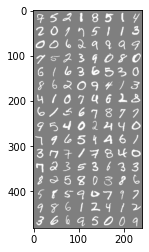

In [3]:
from torchvision.transforms import v2
from torchvision.datasets import CIFAR10, MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

batch_size = 128
transform = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    # v2.Lambda(lambda x: x.view(-1) - 0.5),
])

# Download and load the training/test data
path = './data'
train_data = MNIST(
    path, 
    download=True, 
    train=True, 
    transform=transform,
)
test_data = MNIST(
    path, 
    download=True, 
    train=False, 
    transform=transform,
)

# Create data loaders
train_loader = DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True,
)
test_loader = DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(make_grid(images))

## Define the network

In [15]:
import torch.distributions as distributions

class VAE(nn.Module):
    """
    Variational Autoencoder (VAE) class.
    
    Args:
        input_dim (int): Dimensionality of the input data.
        hidden_dims (List[int]): Dimensionalities of the hidden layers.
        latent_dim (int): Dimensionality of the latent space.
    """
    
    def __init__(self, input_dim:int, hidden_dims:List[int], latent_dim:int):
        super(VAE, self).__init__()

        # build encoder
        # self.encoder = nn.Sequential(
        #     nn.Linear(input_dim, hidden_dim),
        #     nn.SiLU(),  # Swish activation function
        #     nn.Linear(hidden_dim, hidden_dim // 2),
        #     nn.SiLU(),  # Swish activation function
        #     nn.Linear(hidden_dim // 2, hidden_dim // 4),
        #     nn.SiLU(),  # Swish activation function
        #     nn.Linear(hidden_dim // 4, hidden_dim // 8),
        #     nn.SiLU(),  # Swish activation function
        #     nn.Linear(hidden_dim // 8, 2 * latent_dim), # 2 for mean and variance.
        # )
        prev_dim = input_dim
        encoder_layers = []
        for hidden_dim in hidden_dims:
            encoder_layers.append(nn.Linear(prev_dim, hidden_dim))
            encoder_layers.append(nn.SiLU()) # swish activation function
            prev_dim = hidden_dim
        encoder_layers.append(nn.Linear(prev_dim, 2*latent_dim)) # 2 for mean and variance.
        self.encoder = nn.Sequential(*encoder_layers)
        
        # for log_var proper scaling for positive numbers -- else we'll get negative log variances and therefore lots of NaNs during training
        self.softplus = nn.Softplus()

        # build decoder
        # self.decoder = nn.Sequential(
        #     nn.Linear(latent_dim, hidden_dim // 8),
        #     nn.SiLU(),  # Swish activation function
        #     nn.Linear(hidden_dim // 8, hidden_dim // 4),
        #     nn.SiLU(),  # Swish activation function
        #     nn.Linear(hidden_dim // 4, hidden_dim // 2),
        #     nn.SiLU(),  # Swish activation function
        #     nn.Linear(hidden_dim // 2, hidden_dim),
        #     nn.SiLU(),  # Swish activation function
        #     nn.Linear(hidden_dim, input_dim),
        #     nn.Sigmoid(),
        # )
        prev_dim = latent_dim
        decoder_layers = []
        for hidden_dim in reversed(hidden_dims):
            decoder_layers.append(nn.Linear(prev_dim, hidden_dim))
            decoder_layers.append(nn.SiLU())
            prev_dim = hidden_dim
        decoder_layers.append(nn.Linear(prev_dim, input_dim))
        decoder_layers.append(nn.Sigmoid())
        self.decoder = nn.Sequential(*decoder_layers)

    def encode(self, x, eps: float = 1e-8):
        """
        Encodes the input data into the latent space.
        
        Args:
            x (torch.Tensor): Input data.
            eps (float): Small value to avoid numerical instability.
        
        Returns:
            torch.distributions.MultivariateNormal: Normal distribution of the encoded data.
        """
        x = self.encoder(x)
        mu, logvar = torch.chunk(x, 2, dim=-1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)
        
        return distributions.MultivariateNormal(mu, scale_tril=scale_tril)
        
    def reparameterize(self, dist):
        """
        Reparameterizes the encoded data to sample from the latent space.
        
        Args:
            dist (torch.distributions.MultivariateNormal): Normal distribution of the encoded data.
        Returns:
            torch.Tensor: Sampled data from the latent space.
        """
        return dist.rsample()
    
    def decode(self, z):
        """
        Decodes the data from the latent space to the original input space.
        
        Args:
            z (torch.Tensor): Data in the latent space.
        
        Returns:
            torch.Tensor: Reconstructed data in the original input space.
        """
        return self.decoder(z)
    
    def forward(self, x):
        """
        Performs a forward pass of the VAE.
        
        Args:
            x (torch.Tensor): Input data.
            compute_loss (bool): Whether to compute the loss or not.
        
        Returns:
            VAEOutput: VAE output dataclass.
        """
        dist = self.encode(x)
        z = self.reparameterize(dist)
        x_hat = self.decode(z)
        
        return x_hat, z, dist

# instantiate model
latent_dim = 2
hidden_dims = [512, 256, 128, 64]
# hidden_dims = [512]
model = VAE(input_dim=784, hidden_dims=hidden_dims, latent_dim=latent_dim).to(device)
print(model,'\n')

# trainable params amount
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')

# model size
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()
size_all_mb = (param_size + buffer_size) / 1024**2
print('Model size: {:.3f} MB'.format(size_all_mb))

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): SiLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): SiLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): SiLU()
    (8): Linear(in_features=64, out_features=4, bias=True)
  )
  (softplus): Softplus(beta=1, threshold=20)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): SiLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): SiLU()
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): SiLU()
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): SiLU()
    (8): Linear(in_features=512, out_features=784, bias=True)
    (9): Sigmoid()
  )
) 

Number of parameters: 1,149,972
Model size: 4.387 MB


## Begin training

Loss function:

In [16]:
import torch.nn.functional as F

def criterion(x:torch.Tensor, x_hat:torch.Tensor, z:torch.Tensor, dist:distributions.MultivariateNormal):
    # loss_recon = F.mse_loss(x_hat, x, reduction='none').sum(-1).mean()
    loss_recon = F.binary_cross_entropy(x_hat, x, reduction='none').sum(-1).mean()
    # loss_recon = F.binary_cross_entropy(x_hat, x, reduction='sum')
    std_normal = distributions.MultivariateNormal(
        torch.zeros_like(z, device=z.device),
        scale_tril=torch.eye(z.shape[-1], device=z.device).unsqueeze(0).expand(z.shape[0], -1, -1),
    )
    loss_kl = distributions.kl.kl_divergence(dist, std_normal).mean()
    # loss_kl = distributions.kl.kl_divergence(dist, std_normal).sum()
            
    loss = loss_recon + loss_kl

    return loss

Training loop:

In [17]:
import torch.optim as optim
# from rich.progress import track
# from tqdm.auto import tqdm

def train(model, optimizer, train_loader, epochs, device, grad_clip:float=None):
    model.train()  # Set the model to training mode
    
    # loop over epochs
    for epoch in range(epochs):
        loss_epoch = 0 # running loss over epoch

        # loop over batches
        x:torch.Tensor
        # for batch_idx, (x, target) in enumerate(track(train_loader, description=f'Epoch {epoch+1}/{epochs}')):
        # for batch_idx, (x, target) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')):
        for batch_idx, (x, target) in enumerate(train_loader):
            x = x.flatten(1) # flatten data
            x = x.to(device) # move data to device

            optimizer.zero_grad() # zero gradients

            # forward pass and loss calculation
            x_hat, z, dist = model(x)
            loss = criterion(x, x_hat, z, dist)
            loss_epoch += loss.item()

            loss.backward() # propagate loss back

            # gradient clipping
            if grad_clip:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)    
            
            optimizer.step() # update model weights

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", loss_epoch/(batch_idx*batch_size))
    return loss_epoch

optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
train(model, optimizer, train_loader, epochs=50, device=device, grad_clip=1.0)

	Epoch 1 	Average Loss:  0.4020926417448582
	Epoch 2 	Average Loss:  0.35001573628849453
	Epoch 3 	Average Loss:  0.33633673458527297
	Epoch 4 	Average Loss:  0.3299241271029171
	Epoch 5 	Average Loss:  0.3288153645574537
	Epoch 6 	Average Loss:  0.316610313187807
	Epoch 7 	Average Loss:  0.30446320536554367
	Epoch 8 	Average Loss:  0.2990650856851513
	Epoch 9 	Average Loss:  0.2999655465539704
	Epoch 10 	Average Loss:  0.29409672644657964
	Epoch 11 	Average Loss:  0.29157224284787464
	Epoch 12 	Average Loss:  0.28761706857854485
	Epoch 13 	Average Loss:  0.2836405960922567
	Epoch 14 	Average Loss:  0.2853184582458602
	Epoch 15 	Average Loss:  0.2801804802993424
	Epoch 16 	Average Loss:  0.27964915150505865
	Epoch 17 	Average Loss:  0.2773705146824702
	Epoch 18 	Average Loss:  0.2792733581020282
	Epoch 19 	Average Loss:  0.2801760881502404
	Epoch 20 	Average Loss:  0.278996163708532
	Epoch 21 	Average Loss:  0.2759741941132607
	Epoch 22 	Average Loss:  0.2738724042717208
	Epoch 23 	Ave

16020.576629638672

## Plot results

Random sampled z values

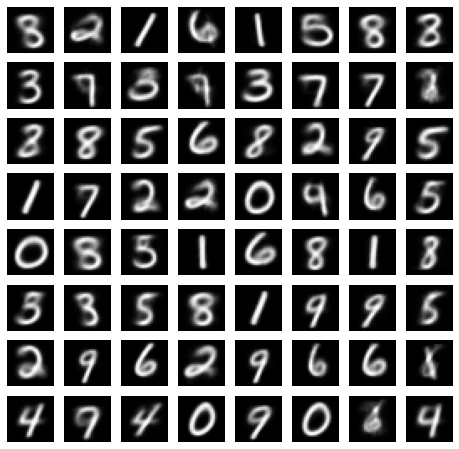

In [30]:
z = torch.randn(64, latent_dim).to(device) # random z values

# forward passes
model.eval()
samples = model.decode(z)
# samples = torch.sigmoid(samples)

# plot generated images
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(samples[i*8+j].view(28, 28).cpu().detach().numpy(), cmap='gray')
        ax[i, j].axis('off')

2D Scatter plot of how well VAE performs on finding the different classes in the training set.  
In the best case, those regions are well separated.

Output()

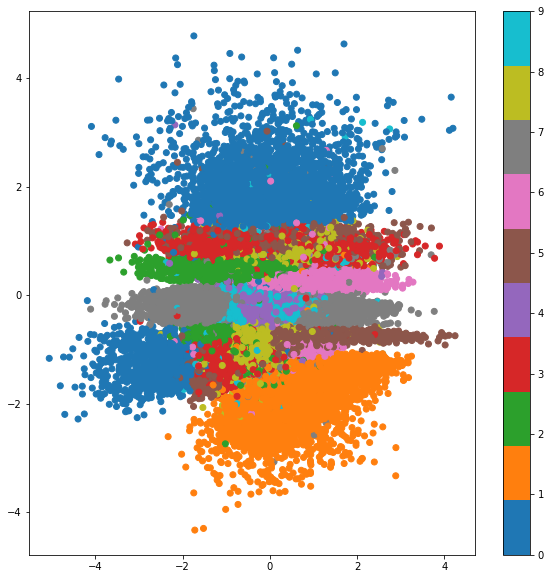

In [19]:
from rich.progress import track

# encode and plot the z values for the train set 
model.eval()
z_all = []
target_all = []
with torch.no_grad():
    for data, target in track(train_loader, description='Encoding'):
        data = data.flatten(1).to(device)
        x_hat, z, dist = model(data)
        z_all.append(z.cpu().numpy())
        target_all.append(target.numpy())
z_all = np.concatenate(z_all, axis=0)
target_all = np.concatenate(target_all, axis=0)

# plot 2d histogram
plt.figure(figsize=(10, 10))
plt.scatter(z_all[:, 0], z_all[:, 1], c=target_all, cmap='tab10')
plt.colorbar()
plt.show()

2D Histogram (log scale)

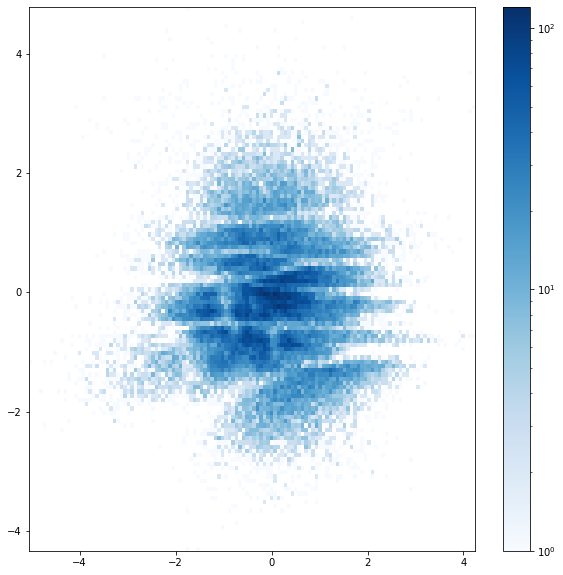

In [20]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(10, 10))
plt.hist2d(z_all[:, 0], z_all[:, 1], bins=128, cmap='Blues', norm=LogNorm())
plt.colorbar()
plt.show()

1D Histogram

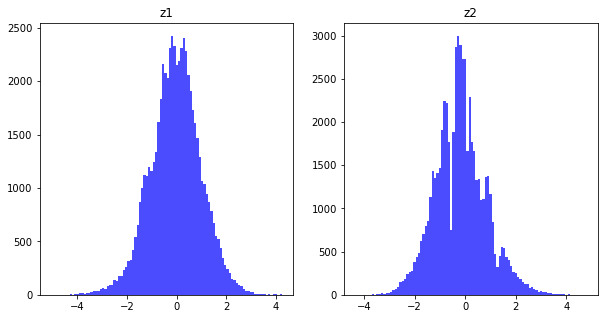

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(z_all[:, 0], bins=100, color='b', alpha=0.7)
ax[0].set_title('z1')
ax[1].hist(z_all[:, 1], bins=100, color='b', alpha=0.7)
ax[1].set_title('z2')
plt.show()

Example how one number changes from left to right when interpolating z

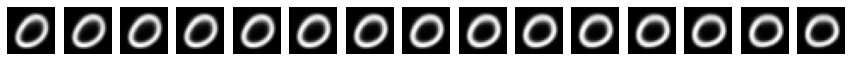

In [29]:
n = 15
z1 = torch.linspace(-0, 1, n)
z2 = torch.zeros_like(z1) + 2
z = torch.stack([z1, z2], dim=-1).to(device)
samples = model.decode(z)
samples = torch.sigmoid(samples)

# plot generated images
fig, ax = plt.subplots(1, n, figsize=(n, 1))
for i in range(n):
    ax[i].imshow(samples[i].view(28, 28).cpu().detach().numpy(), cmap='gray')
    ax[i].axis('off')